In [2]:
#@title Implementação dos modelos em Python (*beta*)
#@markdown Esta célula contém a implementação em Python 3 dos principais modelos de computação vistos na disciplina de Linguagens Formais e Autômatos. 
#@markdown Não é necessário conhecer o código aqui implementado ou mesmo ter um conhecimento profundo da linguagem Python. Acompanhe os exemplos e experimente construir seus próprios modelos.
 
#@markdown >*Execute esta célula (`ctrl+enter` ou clicando no botão ao lado) para que o ambiente seja carregado com as classes implementadas.*
 
from graphviz import Digraph
import re
 
class AP: 
    def __init__(self, Q={}, Sigma={}, Gamma={}, delta={}, q0=0, F={}):
        self.states = Q
        self.inputAlphabet = Sigma
        self.stackAlphabet = Gamma
        self.transition = delta
        self.startState = q0
        self.acceptStates = F 
 
        self.initialize()
 
    def initialize(self, input_string=""):
        self.traces = [[(self.startState,tuple(input_string),())]]
 
    def check(self):
        pass
        
    def hasNext(self):
        return self.traces and (not self.acceptTraces())
    
    def acceptTraces(self):
        return [t for t in self.traces if t[-1][1] == () and t[-1][0] in self.acceptStates]
 
    def step(self):
        updated_traces = []
        for trace in self.traces:
          s, string, stack = trace[-1]
          A = {'', string[0]} if string else {''}
          B = {'', stack[-1]} if stack else {''}
          possible_transitions = [(s,a,b) for a in A for b in B if (s,a,b) in self.transition]          
          for (s,a,b) in possible_transitions:  
            for r,c in self.transition[s,a,b]:
              nstring = string[1:] if a else string
              nstack  = stack[:-1] if b else stack
              nstack  = nstack+(c,) if c else nstack
              if (not (r,nstring,nstack) in trace):
                updated_traces.append(trace+[(r,nstring,nstack)])
        self.traces = updated_traces
 
    def run(self, input_string=0, max_steps=1000):        
        while (self.hasNext()): 
          if max_steps == 0: 
            raise Exception("Timeout")
          self.step()
          max_steps -= 1
        return self.result()
 
    def aceita(self, input_string=0):
        self.initialize(input_string)
        return self.run()
 
    def result(self):
        return True if self.acceptTraces() else (False if (not self.traces) else None)
    
    def visualizar(self):      
        f = Digraph('finite_state_machine', filename='fsm.gv')
        f.attr(rankdir='LR', size='8,5')
 
        f.attr('node', shape='point')
        f.node('')
        
        f.attr('node', shape='doublecircle')
        for n in self.acceptStates:
          f.node(str(n))
 
        f.attr('node', shape='circle')
        for n in self.states.difference(self.acceptStates):
          f.node(str(n))
 
        label = {}        
        for (q,a,b) in self.transition:
          for (r,c) in self.transition[q,a,b]:          
            label[q,r] = label[q,r]+[(a,b,c)] if (q,r) in label else [(a,b,c)]
 
        f.edge('', str(self.startState))
        for (q,r) in label:
          f.edge(str(q),str(r),label=self.graphviz_edge_label_format(label[q,r]))      
          pass
        
        return f
    
    def graphviz_edge_label_format(self,labels=[]):
        epsilon = "\u03BB"
        right_arrow = "\u2192"
        return '\n'.join([(a if (a or a==0) else epsilon) + "," + (b if (b or b==0) else epsilon) + right_arrow + (c if (c or c==0) else epsilon) for (a,b,c) in labels])
        # return '\n'.join([(str(a) if a else epsilon) + "," + (str(b) if b else epsilon) + right_arrow + (str(c) if c else epsilon) for (a,b,c) in labels])
 
class AFN(AP):
  def __init__(self, Q={}, Sigma={}, delta={}, q0=0, F={}):
        delta_pda = {}
        for q,a in delta:
          delta_pda[q,a,''] = {(r,'') for r in delta[q,a]}
        super().__init__(Q,Sigma,{},delta_pda,q0,F)
  
  def graphviz_edge_label_format(self,labels):
      epsilon = "\u03BB"
      return ",".join([(str(a) if (a or a==0) else epsilon) for (a,b,c) in labels])
 
class AFD(AFN):
  def __init__(self, Q={}, Sigma={}, delta={}, q0=0, F={}):
        delta_nfa = {}
        for (q,a) in delta:
          delta_nfa[q,a] = {delta[q,a]}
        super().__init__(Q,Sigma,delta_nfa,q0,F)
 
class ER:
  def __init__(self,regex=None):  
    if (regex == None):
      self.regex = None
    elif (re.match("^[a-zA-Z0-9\(\)\|\*]*$", regex)):
      self.regex = regex
    else:
      raise Exception("Invalid pattern")
 
  def gera(self, input_string):
    if (self.regex == None):
      return False
    else:
      return True if re.match("^"+self.regex+"$",input_string) else False
 
class GLC:
  def __init__(self,V,Sigma,R,S):
      self.variables = V
      self.terminals = Sigma
      # self.rules = R
      self.rules = {(a, tuple(b)) for (a,b) in R}
      self.start = S
 
      self.derivation = []
      self.chomsky = None
  
  def gera(self, string):
      if (not self.chomsky):
        self.chomsky = self.to_chomsky()        
      G = self.chomsky
      
      if len(string) == 0: return (G.start,()) in G.rules
 
      # CYK Algorithm
      n = len(string)
      P = [[[] for x in range(n - y)] for y in range(n)]
      for i,c in enumerate(string):
        for v in [a for (a,b) in G.rules if len(b) == 1 and c in b]:
          P[0][i] += [v]
      for l in range(2, n+1): # borda da iteração
        for s in range(0, n+1-l): # coluna
          for p in range(1, l): # linha
            for u, v in [(a,b) for (a,b) in G.rules if len(b) == 2]:
              if v[0] in P[p-1][s] and v[1] in P[l-p-1][s+p]:
                P[l-1][s] += [u]
      return G.start in P[-1][0]
 
  def print(self):
      rightarrow = "\u2192"
      print(self.start,rightarrow, '|'.join([''.join(y) for x,y in self.rules if x == S]))
      for v in sorted(self.variables.difference(self.start)): 
        print(v,rightarrow, '|'.join([''.join(y) for x,y in self.rules if x == v]))
 
  def replace_eps(self, v, l):
    if not l: return {()}
    result = {(l[0],) + s for s in self.replace_eps(v, tuple(l[1:]))}
    if l[0] == v:
      result.update({tuple(s[1:]) for s in result})
    return result   
 
  def to_chomsky(self):
      n_state = 0
      
      S = '<{}>'.format(n_state)
      Sigma = self.terminals 
      V = {S}.union(self.variables)
      R = {(S,(self.start,))}.union(self.rules)
 
      target = {alpha for alpha in self.variables if (alpha,()) in R}
      while (target):
        for e in target:
          rules = {(alpha,beta) for (alpha,beta) in R if e in beta}
          for (a,b) in rules:
            R.update({(a, beta) for beta in self.replace_eps(e,b)})
          R.discard((e,()))
        target = {alpha for alpha in self.variables if (alpha,()) in R}
      
      target = {(a,b) for (a,b) in R if len(b) == 1 and b[0] in V}
      while (target):
        for u,v in target:
          rules = {b for (a,b) in R if a == v[0]}
          R.update({(u,b) for b in rules})
          R.discard((u,v))
        target = {(a,b) for (a,b) in R if len(b) == 1 and b[0] in V}
      
      target = {(alpha,beta) for (alpha,beta) in R if len(beta) > 2}
      while(target):
        for u,v in target:
          n_state += 1
          state = '<{}>'.format(n_state)
          V.update({state})
          R.update({(u,(v[0],state)),(state, tuple(v[1:]))})
          R.discard((u,v))
        target = {(alpha,beta) for (alpha,beta) in R if len(beta) > 2}
 
      target = {(alpha,beta) for (alpha,beta) in R if len(beta) == 2}
      for u,v in target:
        n = list(v)
        for i in range(2):
          if v[i] in Sigma:
            R.discard((u,(n[0],n[1])))
            n_state += 1
            n[i] = '<{}>'.format(n_state)
            V.update({n[i]})
            R.update({(u,(n[0],n[1]))})
            R.update({(n[i],(v[i],))})
 
      return GLC(V,Sigma,R,S)

# Autômato de Pilha Determinístico

Os **autômatos de pilha** (AP) são modelos de computação que possuem uma memória do tipo FILO (*first in, last out*), fazendo analogia a uma pilha de objetos, onde só podemos ter acesso aquele que está no topo. 

Nesse modelo, temos um alfabeto específico para a escrita nessa memória, chamado de *alfabeto de pilha*. As transições se assemelham àquelas dos autômatos finitos não-determinísticos, porém a ocorrência da transição também leva em conta a informação encontrada no topo da pilha de memória. 

Assim como para AFDs, graficamente descrevemos um AP por meio de uma representação de estados ligados por arestas rotuladas. Utilizamos nessas arestas rótulos do tipo 

$$a, b \rightarrow c$$

para indicar que para a transição ocorrer o autômato espera ler $a$ da entrada e ter $b$ no topo da pilha. Com a transição de estado, o autômato irá desempilhar $b$ e em seu lugar empilhar o símbolo $c$.


A definição formal de um APD difere da definição de AFD pelo uso do alfabeto específico de pilha:

>**Definição**: Um autômato de pilha é uma sextupla $(E, \Sigma, \Gamma, \delta, i, F)$ onde:
>1. $E$ é um conjunto finito de símbolos de estado,
>1. $\Sigma$ é um conjunto finito de símbolos de alfabeto de entrada,
>1. $\Gamma$ é um conjunto finito de símbolos de alfabeto de pilha,
>1. $\delta : E \times \Sigma_\lambda \times \Gamma_\lambda \rightarrow \mathcal{P}(E \times \Gamma_\lambda)$ é a função de transição,
>1. $i \in E$ é o estado inicial, e
>1. $F \subseteq E$ é o conjunto de estados finais.
> 
> onde $\Sigma_\lambda = \Sigma \cup \{\lambda\}$ e $\Gamma_\lambda = \Gamma \cup \{\lambda\}$.


Seja $M = (E, \Sigma, \Gamma, \delta, i, F)$ um APD e $w = w_1w_2...w_n$ uma cadeia sobre $\Sigma_\lambda$, dizemos que $M$ aceita $w$ se existe uma sequência $(~(s_0,x_0), (s_1, x_1),...,(s_n,x_n)~)$ tal que $s_i \in E$ e $x_i \in \Gamma^*$ e
1. $s_0 = q_0$ e $x_0 = \lambda$,
1. $(s_{i+1}, b) \in \delta(s_i,w_{i+1},a)$, para $0 \leq i < n$, onde $x_{i} = at$, $x_{i+1} = bt$, $t \in \Sigma^*$ e $a,b \in \Sigma_\lambda$,
1. $s_n \in F$.

## Implementação em Python

Em nossa implementação, um autômato de pilha é representado pela classe `AP`, cujo construtor segue a Definição acima:

>`M = AP(E,Sigma,Gamma,delta,q0,F)`

A principal diferença para a construção de AFDs é a indicação do alfabeto de pilha e que a função de transição `delta` deve ser um elemento do tipo `dict()` mapeando `estado-entrada-pilha` para um conjunto de pares `estado-pilha`. A seguir um exemplo de construção de APD.

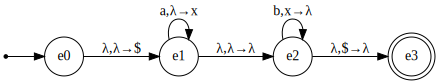

In [ ]:
E = {'e0','e1','e2','e3'}
Sigma = {'a','b'}
Gamma = {'$','x'}
delta = {('e0','' ,'' ):{('e1','$')},
         ('e1','a','' ):{('e1','x')},
         ('e1','' ,'' ):{('e2','' )},
         ('e2','b','x'):{('e2','' )},
         ('e2','' ,'$'):{('e3','' )}}
i = 'e0'
F = {'e3'}
 
M = AP(E,Sigma,Gamma,delta,i,F)
M.visualizar()


Definido o autômato `M`, podemos verificar a aceitação de cadeias por meio da função `M.aceita(entrada)`, onde `entrada` deve ser composta por uma sequência de símbolos pertencentes a `Sigma`. A aceitação de uma palavra retornará o valor `True`.

In [ ]:
M.aceita("aabb")

True

A rejeição de uma palavra retornará o valor `False`.

In [ ]:
M.aceita("aaabb")

False

Você pode também realizar múltiplos testes utilizando listas com casos de testes:

In [ ]:
testes = [("",True), ("ab",True), ("aabb",True), ("aaabbb",True), ("b",False), ("ba",False), ("bbb",False), ("bbaa",False)]
[M.aceita(entrada) == saida for entrada, saida in testes]

[True, True, True, True, True, True, True, True]

Por fim, é possível gerar a representação gráfica do AFD `M` por meio da função `M.visualizar()`. O diagrama de estados é gerado utilizando da biblioteca [`graphviz`]().


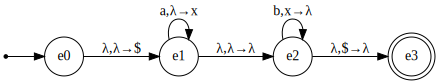

In [ ]:
M.visualizar()

# Exercícios

1. Construa um autômato de pilha que reconheça a linguagem $L = \{a^ib^jc^k \mid i\geq 0, j=2*i+3, k>5\}$

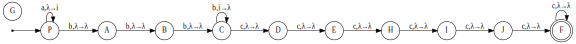

In [ ]:
Q = {'P', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'}
Sigma = {'a','b','c'}
Gamma = {'i','k'}
delta = {
  ('P','a' ,'' ):{('P','i')},
  ('P','b' ,'' ):{('A', '')},
  ('A','b' ,'' ):{('B','')},
  ('B','b' ,'' ):{('C','')},
  ('C','b' ,'i' ):{('C','')},
  ('C','c' ,'' ):{('D','')},
  ('D','c' ,'' ):{('E','')},
  ('E','c' ,'' ):{('H','')},
  ('H','c' ,'' ):{('I','')},
  ('I','c' ,'' ):{('J','')},
  ('J','c' ,'' ):{('F','')},
  ('F','c' ,'' ):{('F','')},
}
i = 'P'
F = {'F'}
 
M = AP(Q,Sigma,Gamma,delta,i,F)
M.visualizar()

2. Construa um autômato de pilha que reconheça a linguagem $L =\{a^ib^jc^k \mid i\geq 1, j=i,  k\leq 3\}$

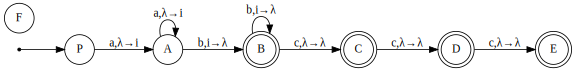

In [ ]:
Q = {'P', 'A', 'B', 'C', 'D', 'F'}
Sigma = {'a','b','c'}
Gamma = {'i','k'}
delta = {
  ('P','a' ,'' ):{('A','i')},
  ('A','a' ,'' ):{('A','i')},
  ('A','b' ,'i' ):{('B','')},
  ('B','b' ,'i' ):{('B','')},
  ('B','c' ,'' ):{('C','')},
  ('C','c' ,'' ):{('D','')},
  ('D','c' ,'' ):{('E','')},
}
i = 'P'
F = {'B','C','D','E'}
 
M = AP(Q,Sigma,Gamma,delta,i,F)
M.visualizar()

3. Construa um autômato de pilha que reconheça a linguagem $L = \{a^ib^jc^k\mid i\geq 1, j=2, 1\leq k\leq 3\}$

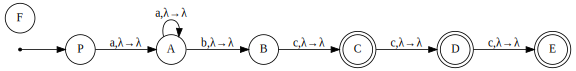

In [ ]:
Q = {'P', 'A', 'B', 'C', 'D', 'F'}
Sigma = {'a','b','c'}
Gamma = {'i','k'}
delta = {
  ('P','a' ,'' ):{('A','')},
  ('A','a' ,'' ):{('A','')},
  ('A','b' ,'' ):{('B','')},
  ('B','c' ,'' ):{('C','')},
  ('C','c' ,'' ):{('D','')},
  ('D','c' ,'' ):{('E','')},
}
i = 'P'
F = {'C','D','E'}
 
M = AP(Q,Sigma,Gamma,delta,i,F)
M.visualizar()

4. Construa um autômato de pilha que reconheça a linguagem gerada pela gramática abaixo:

$$
E\rightarrow  a ~|~E + E ~|~ E - E ~|~ E*E ~|~ E/E ~|~ ( E )
$$

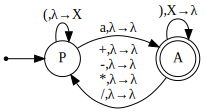

In [9]:
Q = {'P', 'A'}
Sigma = {'a', '+', '-', '*', '/', '(', ')'}
Gamma = {'X'}
delta = {
  ('P','(' ,'' ):{('P','X')},
  ('P','a' ,'' ):{('A','')},
  ('A',')' ,'X'):{('A','')},
  ('A','+' ,'' ):{('P','')},
  ('A','-' ,'' ):{('P','')},
  ('A','*' ,'' ):{('P','')},
  ('A','/' ,'' ):{('P','')},
}
i = 'P'
F = {'A'}
 
M = AP(Q,Sigma,Gamma,delta,i,F)
M.visualizar()

 5. Construa um autômato de pilha que reconheça a linguagem $L =\{a^ib^jc^k \mid i+j = k\}$

 Resposta: Podemos reescrever a descrição da linguagem para $L =\{a^ib^jc^{i+j}\}$ e a partir deste ponto, podemos definir definir um autômato de pilha em função de $i$ e de $j$.

False


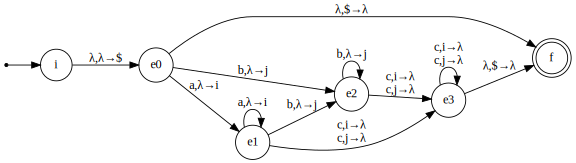

In [ ]:
Q = {'i','e0','e1', 'e2', 'e3','f'}
Sigma = {'a','b','c'}
Gamma = {'$','i','j'}
delta = {('i','' ,'' ):{('e0','$')},
         ('e0','a' ,'' ):{('e1','i')},
         ('e0','b' ,'' ):{('e2','j')},
         ('e1','a' ,'' ):{('e1','i')},
         ('e1','b' ,'' ):{('e2','j')},
         ('e1','c' ,'i' ):{('e3','')},
         ('e1','c' ,'j' ):{('e3','')},
         ('e2','b' ,'' ):{('e2','j')},
         ('e2','c' ,'i' ):{('e3','')},
         ('e2','c' ,'j' ):{('e3','')},
         ('e3','c' ,'i' ):{('e3','')},
         ('e3','c' ,'j' ):{('e3','')},
         ('e0','' ,'$' ):{('f','')},
         ('e3','' ,'$' ):{('f','')}
         }
i = 'i'
F = {'f'}
 
M = AP(E,Sigma,Gamma,delta,i,F)
print(M.aceita("aaacc"))
M.visualizar()
